### Data Preparation 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation, Rescaling
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import time
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D, Dense, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models, layers, optimizers, callbacks

# Ensure that the imports are working correctly
print("All modules imported successfully!")


All modules imported successfully!


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Rescaling

# Define the dataset directory
dataset_directory = r"C:\Users\HP\Desktop\unipd\HDA\My_Project\covid19-pneumonia-normal-chest-xraypa-dataset\COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset"

# Data processing
BATCH_SIZE = 32  # Number of images to process in each batch
IMG_SIZE = (224, 224)  # Size to which each image will be resized
AUTOTUNE = tf.data.AUTOTUNE  # Setting for automatic tuning of data loading

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_directory,  # Path to the dataset directory
    labels='inferred',  # Automatically infer labels from directory structure
    label_mode='categorical',  # Labels will be in categorical format
    batch_size=BATCH_SIZE,  # Batch size for data loading
    image_size=IMG_SIZE,  # Resize images to this size
    shuffle=True,  # Shuffle the dataset for randomness
    seed=123  # Seed for reproducibility
)

class_names = dataset.class_names
print(class_names)  # Print the class names (subdirectories) in the dataset

# Function to split the dataset into training, validation, and test sets
def split_dataset(ds, train_split=0.8, val_split=0.1):
    train_size = int(train_split * len(ds))  # Calculate the number of training samples
    val_size = int(val_split * len(ds))  # Calculate the number of validation samples
    
    train_ds = ds.take(train_size)  # Take the first part of the dataset for training
    val_ds = ds.skip(train_size).take(val_size)  # Take the next part for validation
    test_ds = ds.skip(train_size + val_size)  # The rest is for testing
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)  # Split the dataset

# Data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.05),  # Apply random rotation
    tf.keras.layers.RandomZoom(0.1),  # Apply random zoom
    tf.keras.layers.RandomTranslation(height_factor=0.05, width_factor=0.05),  # Apply random translation
    tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]
])

# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

# Define preprocessing for validation and test datasets (without data augmentation)
preprocess_only_rescaling = tf.keras.Sequential([
    Rescaling(1./255)  # Normalize pixel values to [0, 1]
])

# Apply preprocessing to validation and test datasets
val_ds = val_ds.map(lambda x, y: (preprocess_only_rescaling(x, training=False), y))
test_ds = test_ds.map(lambda x, y: (preprocess_only_rescaling(x, training=False), y))

# Prepare the dataset for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  # Cache, shuffle, and prefetch training data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache and prefetch validation data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  # Cache and prefetch test data


Found 4575 files belonging to 3 classes.
['covid', 'normal', 'pneumonia']


In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks

# Function to build feature extractor
def build_feature_extractor(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),  # Input layer with specified input shape
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # First convolutional layer with 32 filters
        layers.BatchNormalization(),  # Batch normalization layer
        layers.MaxPooling2D((2, 2)),  # Max pooling layer
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Second convolutional layer with 64 filters
        layers.BatchNormalization(),  # Batch normalization layer
        layers.MaxPooling2D((2, 2)),  # Max pooling layer
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Third convolutional layer with 128 filters
        layers.BatchNormalization(),  # Batch normalization layer
        layers.MaxPooling2D((2, 2)),  # Max pooling layer
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Fourth convolutional layer with 256 filters
        layers.BatchNormalization(),  # Batch normalization layer
        layers.MaxPooling2D((2, 2)),  # Max pooling layer
        layers.Flatten()  # Flatten the output to feed into the dense layers
    ])
    return model

# Function to extract features
def extract_features(dataset, feature_extractor):
    all_features = []  # List to store extracted features
    all_labels = []  # List to store corresponding labels
    for images, labels in dataset:
        features = feature_extractor(images)  # Extract features using the feature extractor
        all_features.append(features)  # Append features to the list
        all_labels.append(labels)  # Append labels to the list
    return tf.concat(all_features, axis=0), tf.concat(all_labels, axis=0)  # Concatenate all features and labels along the first axis

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 5:
        return float(lr)  # Keep the learning rate constant for the first 5 epochs
    else:
        return float(lr * tf.math.exp(-0.1))  # Decrease the learning rate exponentially after 5 epochs

lr_schedule = callbacks.LearningRateScheduler(scheduler)  # Create a learning rate scheduler callback

# Define the feature extractor
input_shape = (224, 224, 3)  # Define the input shape
feature_extractor = build_feature_extractor(input_shape)  # Build the feature extractor model

# Extract features from the training dataset
train_features, train_labels = extract_features(train_ds, feature_extractor)  # Extract features and labels from the training dataset

# Extract features from the test dataset
test_features, test_labels = extract_features(test_ds, feature_extractor)  # Extract features and labels from the test dataset

# Extract features from the validation dataset
val_features, val_labels = extract_features(val_ds, feature_extractor)  # Extract features and labels from the validation dataset

# Classifier Model Setup
classifier = models.Sequential([
    layers.Input(shape=train_features.shape[1:]),  # Input layer with the shape of the extracted features
    layers.Dense(256, activation='relu'),  # Dense layer with 256 units and ReLU activation
    layers.Dropout(0.5),  # Dropout layer with a dropout rate of 0.5
    layers.Dense(3, activation='softmax')  # Output layer with 3 units (one for each class) and softmax activation
])

# Compile the classifier
classifier.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    loss='categorical_crossentropy',  # Categorical crossentropy loss function
    metrics=['accuracy']  # Metric to evaluate the model
)

# Train the classifier using the features
history = classifier.fit(
    train_features,  # Training features
    train_labels,  # Training labels
    epochs=20,  # Number of epochs to train for
    validation_data=(val_features, val_labels),  # Validation data
    callbacks=[lr_schedule]  # List of callbacks to apply during training
)


Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 13s 99ms/step - accuracy: 0.5080 - loss: 1.0879 - val_accuracy: 0.7701 - val_loss: 0.6092 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.6923 - loss: 0.7078 - val_accuracy: 0.7522 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.7099 - loss: 0.6688 - val_accuracy: 0.7701 - val_loss: 0.5630 - learning_rate: 0.0010
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7270 - loss: 0.6507 - val_accuracy: 0.7612 - val_loss: 0.5537 - learning_rate: 0.0010
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.7442 - loss: 0.6151 - val_accuracy: 0.8170 - val_loss: 0.5142 - learning_rate: 0.0010
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.7369 - loss: 0.6521 - val_accuracy: 0.8125 - val_loss: 0.5060 - learning_rate: 9.0484e-04
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 11s 98ms/step - accuracy: 0.7314

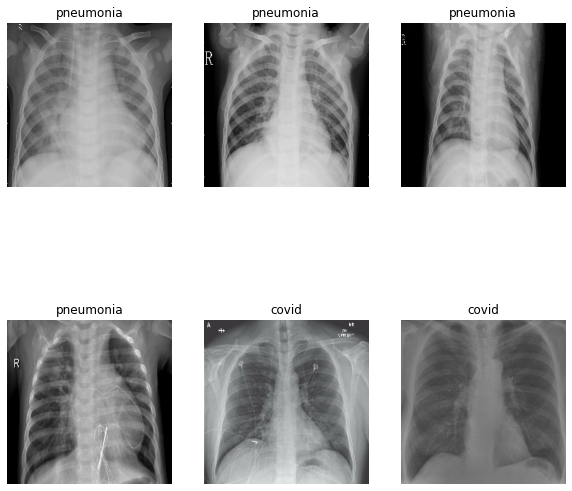

In [5]:
# Retrieve class names from the dataset
class_names = dataset.class_names

# Observing some samples from the dataset
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = class_names[tf.argmax(labels[i])]  # Convert one-hot to index and get class name
        plt.title(label)
        plt.axis("off")
        

### Model Development 

In [6]:
# Function to build a basic CNN model
def build_basic_cnn(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),  # Input layer with specified input shape
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),  # First convolutional layer with 32 filters and ReLU activation
        tf.keras.layers.MaxPooling2D((2, 2)),  # First max pooling layer
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters and ReLU activation
        tf.keras.layers.MaxPooling2D((2, 2)),  # Second max pooling layer
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters and ReLU activation
        tf.keras.layers.MaxPooling2D((2, 2)),  # Third max pooling layer
        tf.keras.layers.Flatten(),  # Flatten the output to feed into the dense layers
        tf.keras.layers.Dense(128, activation='relu'),  # Dense layer with 128 units and ReLU activation
        tf.keras.layers.Dropout(0.5),  # Dropout layer with a dropout rate of 0.5 to prevent overfitting
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with number of units equal to num_classes and softmax activation
    ])
    
    return model  # Return the constructed model


"""
Define Basic CNN Function: Defines a function to build a basic Convolutional Neural Network (CNN).
Input Layer: Adds an input layer with the specified shape.
Convolutional Layers: Adds three convolutional layers, each followed by a max pooling layer to reduce spatial dimensions.
Flatten Layer: Flattens the output from the convolutional layers to feed into the dense layers.
Dense Layer: Adds a dense layer with 128 units and ReLU activation.
Dropout Layer: Adds a dropout layer with a dropout rate of 0.5 to prevent overfitting.
Output Layer: Adds an output layer with the number of units equal to the number of classes and softmax activation to produce class probabilities.
Return Model: Returns the constructed model.
"""



In [44]:
# CNN Model with Depth-Wise Convolutional Layers
import tensorflow as tf

# Function to build an advanced CNN model with depth-wise convolutional layers
def build_advanced_depthwise_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)  # Input layer with specified input shape
    x = data_augmentation(inputs)  # Apply data augmentation

    # Define a convolutional block with depth-wise separable convolutions
    def conv_block(x, filters, kernel_size, padding='same', strides=1):
        x = tf.keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, use_bias=False, strides=strides)(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
        x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
        return x

    # Define a residual block with depth-wise separable convolutions
    def residual_block(x, filters, kernel_size, padding='same', strides=1):
        residual = tf.keras.layers.Conv2D(filters, (1, 1), strides=strides, padding=padding, use_bias=False)(x)
        residual = tf.keras.layers.BatchNormalization()(residual)  # Apply batch normalization to the residual path
        
        x = tf.keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, use_bias=False, strides=strides)(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
        x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
        
        x = tf.keras.layers.SeparableConv2D(filters, kernel_size, padding=padding, use_bias=False, strides=strides)(x)
        x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
        
        x = tf.keras.layers.add([x, residual])  # Add the input (residual connection) to the output of the block
        x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
        return x

    # Construct the CNN model using the defined blocks
    x = conv_block(x, 32, (3, 3))  # Apply the first convolutional block
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    x = residual_block(x, 64, (3, 3))  # Apply the first residual block
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    x = residual_block(x, 128, (3, 3))  # Apply the second residual block
    x = tf.keras.layers.Dropout(0.3)(x)  # Apply dropout for regularization
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    x = residual_block(x, 256, (3, 3))  # Apply the third residual block
    x = tf.keras.layers.Dropout(0.4)(x)  # Apply dropout for regularization
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    x = tf.keras.layers.GlobalAveragePooling2D()(x)  # Apply global average pooling
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Fully connected layer with L2 regularization
    x = tf.keras.layers.Dropout(0.5)(x)  # Apply dropout for regularization
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)  # Create the model
    return model  # Return the constructed model



In [32]:
# Function to build an advanced CNN model with attention mechanisms
def build_advanced_cnn_with_attention(input_shape, num_classes):
    input_layer = tf.keras.layers.Input(input_shape)  # Input layer with specified input shape
    
    # Initial feature extraction layer with Batch Normalization
    x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(input_layer)  # First convolutional layer with 32 filters
    x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
    x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling
    
    x = tf.keras.layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)  # Second convolutional layer with 64 filters
    x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
    x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    # Additional convolutional layers
    x = tf.keras.layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)  # Third convolutional layer with 128 filters
    x = tf.keras.layers.BatchNormalization()(x)  # Apply batch normalization
    x = tf.keras.layers.Activation('relu')(x)  # Apply ReLU activation
    x = tf.keras.layers.SpatialDropout2D(0.2)(x)  # Apply spatial dropout with a dropout rate of 0.2
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)  # Apply max pooling

    # Spatial attention mechanism
    spatial_attention = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(x)  # Convolutional layer for spatial attention
    x = tf.keras.layers.Multiply()([x, spatial_attention])  # Multiply input by spatial attention weights

    # Channel-wise attention mechanism
    attention_feature_map = tf.keras.layers.Conv2D(128, (1, 1), use_bias=False)(x)  # Convolutional layer for channel-wise attention
    attention_feature_map = tf.keras.layers.BatchNormalization()(attention_feature_map)  # Apply batch normalization
    attention_feature_map = tf.keras.layers.Activation('sigmoid')(attention_feature_map)  # Apply sigmoid activation
    x = tf.keras.layers.Multiply()([x, attention_feature_map])  # Multiply input by channel-wise attention weights

    # Additional dropout after attention mechanisms
    x = tf.keras.layers.Dropout(0.6)(x)  # Apply dropout with a dropout rate of 0.6 for additional regularization

    # Global Average Pooling and classifier
    gap = tf.keras.layers.GlobalAveragePooling2D()(x)  # Apply global average pooling
    dense = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(gap)  # Fully connected layer with L2 regularization
    dropout = tf.keras.layers.Dropout(0.5)(dense)  # Apply dropout with a dropout rate of 0.5
    output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')(dropout)  # Output layer with softmax activation

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)  # Create the model
    
    return model  # Return the constructed model


"""
Define Advanced CNN with Attention Function: Defines a function to build an advanced CNN model using attention mechanisms.
Input Layer: Adds an input layer with the specified shape.
Initial Convolutional Layers: Adds convolutional layers with batch normalization and ReLU activation, followed by max pooling.
Spatial Dropout: Applies spatial dropout to prevent overfitting.
Spatial Attention Mechanism: Adds a spatial attention mechanism using a convolutional layer with sigmoid activation, followed by element-wise multiplication.
Channel-wise Attention Mechanism: Adds a channel-wise attention mechanism using a convolutional layer, batch normalization, and sigmoid activation, followed by element-wise multiplication.
Dropout for Regularization: Applies additional dropout to prevent overfitting.
Global Average Pooling: Applies global average pooling to reduce the spatial dimensions.
Fully Connected Layer and Output Layer: Adds a fully connected layer with L2 regularization, followed by dropout and an output layer with softmax activation.
Return Model: Returns the constructed model.
"""



'\nDefine Advanced CNN with Attention Function: Defines a function to build an advanced CNN model using attention mechanisms.\nInput Layer: Adds an input layer with the specified shape.\nInitial Convolutional Layers: Adds convolutional layers with batch normalization and ReLU activation, followed by max pooling.\nSpatial Dropout: Applies spatial dropout to prevent overfitting.\nSpatial Attention Mechanism: Adds a spatial attention mechanism using a convolutional layer with sigmoid activation, followed by element-wise multiplication.\nChannel-wise Attention Mechanism: Adds a channel-wise attention mechanism using a convolutional layer, batch normalization, and sigmoid activation, followed by element-wise multiplication.\nDropout for Regularization: Applies additional dropout to prevent overfitting.\nGlobal Average Pooling: Applies global average pooling to reduce the spatial dimensions.\nFully Connected Layer and Output Layer: Adds a fully connected layer with L2 regularization, followe

In [33]:
# DenseNet Model
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Concatenate, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Function to create a convolutional block for DenseNet
def conv_block(x, growth_rate, name, dropout_rate=0.2):
    """A building block for a dense block."""
    x1 = BatchNormalization(name=name + '_bn')(x)  # Batch normalization
    x1 = Activation('relu', name=name + '_relu')(x1)  # ReLU activation
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False, name=name + '_conv1')(x1)  # 1x1 convolution
    x1 = BatchNormalization(name=name + '_bn2')(x1)  # Batch normalization
    x1 = Activation('relu', name=name + '_relu2')(x1)  # ReLU activation
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False, name=name + '_conv2')(x1)  # 3x3 convolution
    if dropout_rate:  # Apply dropout if specified
        x1 = Dropout(dropout_rate, name=name + '_dropout')(x1)
    x = Concatenate(name=name + '_concat')([x, x1])  # Concatenate input and output
    return x

# Function to create a dense block consisting of multiple convolutional blocks
def dense_block(x, num_layers, growth_rate, name, dropout_rate=0.2):
    """Construct a Dense Block"""
    for i in range(num_layers):  # Iterate through the number of layers
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1), dropout_rate=dropout_rate)  # Add convolutional block
    return x

# Function to create a transition layer between dense blocks
def transition_layer(x, reduction, name, dropout_rate=0.2):
    """A transition layer for DenseNet."""
    x = BatchNormalization(name=name + '_bn')(x)  # Batch normalization
    x = Activation('relu', name=name + '_relu')(x)  # ReLU activation
    x = Conv2D(int(tf.keras.backend.int_shape(x)[-1] * reduction), (1, 1), use_bias=False, name=name + '_conv')(x)  # 1x1 convolution
    if dropout_rate:  # Apply dropout if specified
        x = Dropout(dropout_rate, name=name + '_dropout')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2), name=name + '_pool')(x)  # Average pooling
    return x

# Function to build the DenseNet model
def DenseNet(input_shape, num_classes, num_blocks, growth_rate, num_layers, reduction, dropout_rate=0.2):
    """Builds the DenseNet."""
    inputs = tf.keras.Input(shape=input_shape, name='input')  # Input layer

    x = Conv2D(growth_rate * 2, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1_conv')(inputs)  # Initial convolution
    x = BatchNormalization(name='conv1_bn')(x)  # Batch normalization
    x = Activation('relu', name='conv1_relu')(x)  # ReLU activation
    x = AveragePooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)  # Initial pooling

    for i in range(num_blocks):  # Iterate through the number of blocks
        x = dense_block(x, num_layers[i], growth_rate, name='conv' + str(i + 2), dropout_rate=dropout_rate)  # Add dense block
        if i != num_blocks - 1:  # No transition layer after the last dense block
            x = transition_layer(x, reduction, name='pool' + str(i + 2), dropout_rate=dropout_rate)  # Add transition layer
    
    x = BatchNormalization(name='bn')(x)  # Batch normalization
    x = Activation('relu', name='relu')(x)  # ReLU activation
    x = GlobalAveragePooling2D(name='avg_pool')(x)  # Global average pooling
    if dropout_rate:  # Apply dropout if specified
        x = Dropout(dropout_rate, name='global_dropout')(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01), name='fc')(x)  # Output layer with softmax activation

    model = Model(inputs, outputs, name='densenet')  # Create the model

    return model  # Return the constructed model


"""
Import TensorFlow and Layers: Import necessary modules and layers from TensorFlow.
conv_block Function: Defines a convolutional block with batch normalization, ReLU activation, and dropout.
dense_block Function: Constructs a dense block consisting of multiple convolutional blocks.
transition_layer Function: Creates a transition layer between dense blocks with batch normalization, ReLU activation, convolution, and pooling.
DenseNet Function: Builds the DenseNet model by stacking dense blocks and transition layers, followed by global average pooling, dropout, and a fully connected layer with softmax activation.
"""



'\nImport TensorFlow and Layers: Import necessary modules and layers from TensorFlow.\nconv_block Function: Defines a convolutional block with batch normalization, ReLU activation, and dropout.\ndense_block Function: Constructs a dense block consisting of multiple convolutional blocks.\ntransition_layer Function: Creates a transition layer between dense blocks with batch normalization, ReLU activation, convolution, and pooling.\nDenseNet Function: Builds the DenseNet model by stacking dense blocks and transition layers, followed by global average pooling, dropout, and a fully connected layer with softmax activation.\n'

In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, callbacks, metrics
import os
import time

# Function to print model summary
def print_model_summary(model):
    model.summary()  # Print a summary of the model architecture

# Custom F1-score metric
import tensorflow as tf
from tensorflow.keras import backend as K

def f1_score(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert predictions to binary
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)  # True positives
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)  # False positives
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)  # False negatives
    
    p = tp / (tp + fp + K.epsilon())  # Precision
    r = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * p * r / (p + r + K.epsilon())  # F1 score
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)  # Handle NaN cases
    return K.mean(f1)  # Return mean F1 score

def compute_model_memory_usage(model, batch_size):
    """Calculates the memory usage of a model"""
    shapes_mem_count = 0
    for layer in model.layers:
        if hasattr(layer, 'output_shape'):  # Check if layer has an output shape
            out_shape = layer.output_shape
            if type(out_shape) is list:
                out_shape = out_shape[0]
            single_layer_mem = 1
            for s in out_shape:
                if s is None:
                    continue
                single_layer_mem *= s
            shapes_mem_count += single_layer_mem

    trainable_count = sum([tf.keras.backend.count_params(p) for p in model.trainable_weights])  # Trainable parameters
    non_trainable_count = sum([tf.keras.backend.count_params(p) for p in model.non_trainable_weights])  # Non-trainable parameters

    # Memory usage in Bytes -> convert to Megabytes
    total_memory = 4.0 * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = total_memory / (1024 ** 2)  # Convert to MB
    return gbytes

# General EarlyStopping and LearningRateScheduler
early_stopping_callback = callbacks.EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    mode='max',  # Maximize the monitored quantity
    verbose=1  # Verbosity mode
)

# Ensure the directory for model checkpoints exists
os.makedirs('model_checkpoints', exist_ok=True)

# Checkpoints for each model
checkpoint_basic_cnn = callbacks.ModelCheckpoint(
    'model_checkpoints/basic_cnn.keras', 
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,  # Save only the best model
    mode='max',  # Maximize the monitored quantity
    verbose=1  # Verbosity mode
)

checkpoint_depthwise_cnn = callbacks.ModelCheckpoint(
    'model_checkpoints/depthwise_cnn.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_attention_cnn = callbacks.ModelCheckpoint(
    'model_checkpoints/attention_cnn.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

checkpoint_densenet = callbacks.ModelCheckpoint(
    'model_checkpoints/densenet.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Callback lists for each model
callbacks_basic_cnn = [checkpoint_basic_cnn, early_stopping_callback, lr_schedule]
callbacks_depthwise_cnn = [checkpoint_depthwise_cnn, early_stopping_callback, lr_schedule]
callbacks_attention_cnn = [checkpoint_attention_cnn, early_stopping_callback, lr_schedule]
callbacks_densenet = [checkpoint_densenet, early_stopping_callback, lr_schedule]

# Function to train the model
def train_model(model, train_ds, val_ds, callbacks, epochs=10):
    start_time = time.time()  # Start timer
    history = model.fit(
        train_ds,
        epochs=epochs,  # Number of epochs to train
        validation_data=val_ds,  # Validation dataset
        callbacks=callbacks,  # List of callbacks
        verbose=1  # Verbosity mode
    )
    end_time = time.time()  # End timer
    training_time = end_time - start_time  # Calculate training time
    
    print("\nTraining completed. Final epoch metrics:")
    print("Train Loss: {:.4f}, Train Accuracy: {:.4f}".format(
        history.history['loss'][-1], history.history['accuracy'][-1]))
    print("Validation Loss: {:.4f}, Validation Accuracy: {:.4f}".format(
        history.history['val_loss'][-1], history.history['val_accuracy'][-1]))
    print(f"Total training time for {epochs} epochs: {training_time:.2f} seconds")
    return history, training_time

# Compile the model with additional metrics
def compile_model(model):
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),  # Adam optimizer
        loss='categorical_crossentropy',  # Loss function
        metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(name='auc'), f1_score]  # List of metrics
    )
    return model

# Inference Time Measurement
def evaluate_inference_time(model, test_ds):
    num_samples = tf.data.experimental.cardinality(test_ds).numpy()  # Number of samples in test dataset
    start_time = time.time()  # Start timer
    predictions = model.predict(test_ds)  # Get predictions
    end_time = time.time()  # End timer
    average_inference_time = (end_time - start_time) / num_samples  # Calculate average inference time per sample
    print(f"Average inference time per sample: {average_inference_time:.4f} seconds")
    return average_inference_time

# Function to save and evaluate model size on Disk
def save_and_evaluate_model_size(model, model_name):
    model_save_path = f"{model_name}.keras"  # Define model save path
    model.save(model_save_path)  # Save the model
    model_size = os.path.getsize(model_save_path) / (1024 * 1024)  # Get model size in MB
    return model_size

# Number of classes and input shape
num_classes = 3  # Assuming 3 classes: COVID-19, pneumonia, normal
input_shape = (224, 224, 3)  # Input shape for the images

# Create and compile models for the original image shape
basic_cnn = compile_model(build_basic_cnn(input_shape, num_classes))
advanced_cnn_with_attention = compile_model(build_advanced_cnn_with_attention(input_shape, num_classes))
advanced_depthwise_cnn = compile_model(build_advanced_depthwise_cnn(input_shape, num_classes))
densenet = compile_model(DenseNet(input_shape, num_classes, num_blocks=3, growth_rate=32, num_layers=[6, 12, 24], reduction=0.5))


### Training

In [12]:
# Train the Basic CNN model as an example
print("********************************* Start training basic CNN architecture model ********************************")
history_basic_cnn, training_time_basic_cnn = train_model(
    basic_cnn, 
    train_ds, 
    val_ds, 
    callbacks=callbacks_basic_cnn, 
    epochs= 20
)

# Evaluate model complexity
print("Evaluating model complexity for basic CNN...")
print_model_summary(basic_cnn)
memory_usage_basic_cnn = compute_model_memory_usage(basic_cnn, BATCH_SIZE)
print(f"Estimated memory usage: {memory_usage_basic_cnn:.2f} MB")

# Evaluate model performance
print("Evaluating basic CNN model...")
test_metrics = basic_cnn.evaluate(test_ds)
print(f"Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): {test_metrics}")

# Measure inference time
print("Measuring inference time for basic CNN...")
inference_time_basic_cnn = evaluate_inference_time(basic_cnn, test_ds)
print(f"Average inference time for basic CNN model: {inference_time_basic_cnn:.4f} seconds per sample")

# Evaluate model size
print("Evaluating disk space used by basic CNN...")
model_size_basic_cnn = save_and_evaluate_model_size(basic_cnn, "basic_cnn")
print(f"Disk space occupied by basic CNN model: {model_size_basic_cnn:.2f} MB")



********************************* Start training basic CNN architecture model ********************************
Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.8171 - auc: 0.9414 - f1_score: 0.8018 - loss: 0.4794 - precision: 0.8416 - recall: 0.7806
Epoch 1: val_accuracy did not improve from 0.85938
114/114 ━━━━━━━━━━━━━━━━━━━━ 64s 561ms/step - accuracy: 0.8171 - auc: 0.9414 - f1_score: 0.8018 - loss: 0.4795 - precision: 0.8416 - recall: 0.7805 - val_accuracy: 0.8594 - val_auc: 0.9588 - val_f1_score: 0.8559 - val_loss: 0.3875 - val_precision: 0.8779 - val_recall: 0.8504 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 529ms/step - accuracy: 0.8364 - auc: 0.9490 - f1_score: 0.8292 - loss: 0.4388 - precision: 0.8605 - recall: 0.8071
Epoch 2: val_accuracy improved from 0.85938 to 0.87054, saving model to model_checkpoints/basic_cnn.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 64s 562ms/step - accuracy: 0.8364 - auc: 0.9491 - f1_score: 0.8292 - loss: 0.4388 - pre

Epoch 15/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9799 - auc: 0.9990 - f1_score: 0.9782 - loss: 0.0596 - precision: 0.9807 - recall: 0.9770
Epoch 15: val_accuracy did not improve from 0.91518
114/114 ━━━━━━━━━━━━━━━━━━━━ 60s 530ms/step - accuracy: 0.9799 - auc: 0.9990 - f1_score: 0.9782 - loss: 0.0596 - precision: 0.9807 - recall: 0.9770 - val_accuracy: 0.9152 - val_auc: 0.9644 - val_f1_score: 0.9077 - val_loss: 0.5995 - val_precision: 0.9191 - val_recall: 0.9129 - learning_rate: 3.6788e-04
Epoch 16/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.9824 - auc: 0.9994 - f1_score: 0.9827 - loss: 0.0496 - precision: 0.9867 - recall: 0.9804
Epoch 16: val_accuracy improved from 0.91518 to 0.92188, saving model to model_checkpoints/basic_cnn.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 61s 532ms/step - accuracy: 0.9824 - auc: 0.9994 - f1_score: 0.9827 - loss: 0.0496 - precision: 0.9867 - recall: 0.9804 - val_accuracy: 0.9219 - val_auc: 0.9663 - val_f1_score: 0.9133 - val_l

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,508,043 (127.82 MB)

 Trainable params: 11,169,347 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,696 (85.22 MB)

Estimated memory usage: 42.61 MB
Evaluating basic CNN model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - accuracy: 0.8938 - auc: 0.9435 - f1_score: 0.8979 - loss: 0.8580 - precision: 0.8938 - recall: 0.8938
Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): [0.8072119355201721, 0.9018788933753967, 0.9519941210746765, 0.9040759801864624, 0.9018788933753967, 0.9018788933753967]
Measuring inference time for basic CNN...
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step
Average inference time per sample: 0.2002 seconds
Average inference time for basic CNN model: 0.2002 seconds per sample
Evaluating disk space used by basic CNN...
Disk space occupied by basic CNN model: 127.86 MB


In [45]:
# Training Depth-Wise Convolutional CNN
print("***************************** Start training depth-wise convolutional model ******************************")

input_shape = (224, 224, 3)
num_classes = 3
advanced_depthwise_cnn = build_advanced_depthwise_cnn(input_shape, num_classes)
compiled_depthwise_cnn = compile_model(advanced_depthwise_cnn)

history_depthwise_cnn, training_time_depthwise_cnn = train_model(
    compiled_depthwise_cnn, 
    train_ds, 
    val_ds, 
    callbacks=callbacks_depthwise_cnn, 
    epochs=20
)

# Evaluate model complexity
print("Evaluating model complexity for Depth-Wise Convolutional CNN...")
print_model_summary(compiled_depthwise_cnn)
memory_usage_depthwise_cnn = compute_model_memory_usage(compiled_depthwise_cnn, BATCH_SIZE)
print(f"Estimated memory usage: {memory_usage_depthwise_cnn:.2f} MB")

# Evaluate model performance
print("Evaluating Depth-Wise Convolutional CNN model...")
test_metrics = compiled_depthwise_cnn.evaluate(test_ds)
print(f"Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): {test_metrics}")

# Measure inference time
print("Measuring inference time for Depth-Wise Convolutional CNN...")
inference_time_advanced_depthwise_cnn = evaluate_inference_time(compiled_depthwise_cnn, test_ds)
print(f"Average inference time for Depth-Wise Convolutional CNN model: {inference_time_advanced_depthwise_cnn:.4f} seconds per sample")

# Evaluate model size
print("Evaluating disk space used by Depth-Wise Convolutional CNN...")
model_size_advanced_depthwise_cnn = save_and_evaluate_model_size(compiled_depthwise_cnn, "advanced_depthwise_cnn")
print(f"Disk space occupied by Depth-Wise Convolutional CNN: {model_size_advanced_depthwise_cnn:.2f} MB")



***************************** Start training depth-wise convolutional model ******************************
Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5678 - auc: 0.7341 - f1_score: 0.5115 - loss: 2.5865 - precision_19: 0.5940 - recall_19: 0.4919
Epoch 1: val_accuracy improved from -inf to 0.32589, saving model to model_checkpoints/depthwise_cnn.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.5685 - auc: 0.7347 - f1_score: 0.5123 - loss: 2.5825 - precision_19: 0.5948 - recall_19: 0.4925 - val_accuracy: 0.3259 - val_auc: 0.4944 - val_f1_score: 0.0000e+00 - val_loss: 2.0479 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7213 - auc: 0.8826 - f1_score: 0.6988 - loss: 1.5095 - precision_19: 0.7575 - recall_19: 0.6577
Epoch 2: val_accuracy did not improve from 0.32589
114/114 ━━━━━━━━━━━━━━━━━━━━ 246s 2s/step - accuracy: 0.7215 - auc: 0.8827 - f1_score: 0.69

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_22[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_72 │ (None, 224, 224,  │        123 │ sequential[12][0] │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_78       │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_60    │ (None, 112, 112,  │          0 │ activation_78[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_73 │ (None, 112, 112,  │      2,336 │ max_pooling2d_60… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_79       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_74 │ (None, 112, 112,  │      4,672 │ activation_79[0]… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 112, 112,  │      2,048 │ max_pooling2d_60… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ separable_conv2d… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_80       │ (None, 112, 112,  │          0 │ add_30[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_61    │ (None, 56, 56,    │          0 │ activation_80[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_75 │ (None, 56, 56,    │      8,768 │ max_pooling2d_61

 Total params: 645,468 (2.46 MB)

 Trainable params: 214,238 (836.87 KB)

 Non-trainable params: 2,752 (10.75 KB)

 Optimizer params: 428,478 (1.63 MB)

Estimated memory usage: 19.20 MB
Evaluating Depth-Wise Convolutional CNN model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 389ms/step - accuracy: 0.8200 - auc: 0.9463 - f1_score: 0.8017 - loss: 0.5121 - precision_19: 0.8403 - recall_19: 0.7709
Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): [0.5143952965736389, 0.8204593062400818, 0.9450512528419495, 0.8053995370864868, 0.8408071994781494, 0.7828810214996338]
Measuring inference time for Depth-Wise Convolutional CNN...
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 440ms/step
Average inference time per sample: 0.5185 seconds
Average inference time for Depth-Wise Convolutional CNN model: 0.5185 seconds per sample
Evaluating disk space used by Depth-Wise Convolutional CNN...
Disk space occupied by Depth-Wise Convolutional CNN: 2.63 MB


In [15]:
# Training CNN with Attention Mechanism
print("***************************** Start training CNN with Attention Mechanism model *****************************")

# Ensure the model is compiled with the necessary metrics
compiled_attention_cnn = compile_model(advanced_cnn_with_attention)

history_attention_cnn, training_time_attention_cnn = train_model(
    compiled_attention_cnn, 
    train_ds, 
    val_ds, 
    callbacks=callbacks_attention_cnn, 
    epochs=20
)

# Evaluate model complexity
print("Evaluating model complexity for CNN with Attention Mechanism...")
print_model_summary(compiled_attention_cnn)
memory_usage_attention_cnn = compute_model_memory_usage(compiled_attention_cnn, BATCH_SIZE)
print(f"Estimated memory usage: {memory_usage_attention_cnn:.2f} MB")

# Evaluate model performance
print("Evaluating CNN with Attention Mechanism model...")
test_metrics = compiled_attention_cnn.evaluate(test_ds)
print(f"Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): {test_metrics}")

# Measure inference time
print("Measuring inference time for CNN with Attention Mechanism...")
inference_time_advanced_cnn_with_attention = evaluate_inference_time(compiled_attention_cnn, test_ds)
print(f"Average inference time for CNN with Attention Mechanism: {inference_time_advanced_cnn_with_attention:.4f} seconds per sample")

# Evaluate model size
print("Evaluating disk space used by CNN with Attention Mechanism...")
model_size_advanced_cnn_with_attention = save_and_evaluate_model_size(compiled_attention_cnn, "advanced_cnn_with_attention")
print(f"Disk space occupied by CNN with Attention Mechanism: {model_size_advanced_cnn_with_attention:.2f} MB")



***************************** Start training CNN with Attention Mechanism model *****************************
Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8049 - auc: 0.9224 - f1_score: 0.7883 - loss: 0.6048 - precision_6: 0.8297 - recall_6: 0.7624
Epoch 1: val_accuracy improved from 0.59375 to 0.70089, saving model to model_checkpoints/attention_cnn.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.8049 - auc: 0.9224 - f1_score: 0.7883 - loss: 0.6047 - precision_6: 0.8297 - recall_6: 0.7625 - val_accuracy: 0.7009 - val_auc: 0.8680 - val_f1_score: 0.6573 - val_loss: 0.8153 - val_precision_6: 0.7233 - val_recall_6: 0.6652 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8210 - auc: 0.9381 - f1_score: 0.8037 - loss: 0.5438 - precision_6: 0.8409 - recall_6: 0.7832
Epoch 2: val_accuracy did not improve from 0.70089
114/114 ━━━━━━━━━━━━━━━━━━━━ 144s 1s/step - accuracy: 0.8210 - auc: 0.9381 - f1_score: 0.8038 - loss: 0.5

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 224, 224,  │        864 │ input_layer_7[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 224, 224,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 112, 112,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 112, 112,  │     18,432 │ max_pooling2d_11… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_12[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 56, 56,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 56, 56,    │     73,728 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_13[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d   │ (None, 56, 56,    │          0 │ activation_2[0][… │
│ (SpatialDropout2D)  │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 28, 28,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 28, 28, 1) │      1,153 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 28,    │          0 │ max_pooling2d_13… │
│                     │ 128)              │            │ conv2d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 28, 28,    │     16,384 │ multiply[0][0]    │
│                     │ 128)              │            │                 

 Total params: 385,198 (1.47 MB)

 Trainable params: 128,164 (500.64 KB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 256,330 (1001.29 KB)

Estimated memory usage: 0.49 MB
Evaluating CNN with Attention Mechanism model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 338ms/step - accuracy: 0.3155 - auc: 0.5451 - f1_score: 0.1846 - loss: 6.1598 - precision_6: 0.3155 - recall_6: 0.3155
Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): [5.829306125640869, 0.3361169099807739, 0.5685131549835205, 0.19673167169094086, 0.3361169099807739, 0.3361169099807739]
Measuring inference time for CNN with Attention Mechanism...
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 284ms/step
Average inference time per sample: 0.3443 seconds
Average inference time for CNN with Attention Mechanism: 0.3443 seconds per sample
Evaluating disk space used by CNN with Attention Mechanism...
Disk space occupied by CNN with Attention Mechanism: 1.56 MB


In [16]:
# Training DenseNet Model
print("*************************************** Start training DenseNet model ***************************************")

# Ensure the model is compiled with the necessary metrics
compiled_densenet = compile_model(densenet)

history_densenet, training_time_densenet = train_model(
    compiled_densenet, 
    train_ds, 
    val_ds, 
    callbacks=callbacks_densenet, 
    epochs=20
)

# Evaluate model complexity
print("Evaluating model complexity for DenseNet...")
print_model_summary(compiled_densenet)
memory_usage_densenet = compute_model_memory_usage(compiled_densenet, BATCH_SIZE)
print(f"Estimated memory usage: {memory_usage_densenet:.2f} MB")

# Evaluate model performance
print("Evaluating DenseNet model...")
test_metrics = compiled_densenet.evaluate(test_ds)
print(f"Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): {test_metrics}")

# Measure inference time
print("Measuring inference time for DenseNet...")
inference_time_densenet = evaluate_inference_time(compiled_densenet, test_ds)
print(f"Average inference time for DenseNet model: {inference_time_densenet:.4f} seconds per sample")

# Evaluate model size
print("Evaluating disk space used by DenseNet...")
model_size_densenet = save_and_evaluate_model_size(compiled_densenet, "densenet")
print(f"Disk space occupied by DenseNet model: {model_size_densenet:.2f} MB")



*************************************** Start training DenseNet model ***************************************
Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6732 - auc: 0.8361 - f1_score: 0.6320 - loss: 0.8319 - precision_7: 0.7119 - recall_7: 0.6042
Epoch 1: val_accuracy improved from -inf to 0.32589, saving model to model_checkpoints/densenet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 906s 7s/step - accuracy: 0.6737 - auc: 0.8365 - f1_score: 0.6327 - loss: 0.8311 - precision_7: 0.7123 - recall_7: 0.6049 - val_accuracy: 0.3259 - val_auc: 0.5078 - val_f1_score: 0.1623 - val_loss: 7.3034 - val_precision_7: 0.3266 - val_recall_7: 0.3259 - learning_rate: 0.0010
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7930 - auc: 0.9199 - f1_score: 0.7864 - loss: 0.6018 - precision_7: 0.8093 - recall_7: 0.7699
Epoch 2: val_accuracy improved from 0.32589 to 0.38616, saving model to model_checkpoints/densenet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 902s 8s/step - accuracy: 0.793

Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ conv1_relu[0][0]  │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_bn     │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_relu   │ (None, 56, 56,    │          0 │ conv2_block1_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_conv1  │ (None, 56, 56,    │      8,192 │ conv2_block1_rel… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_bn2    │ (None, 56, 56,    │        512 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_relu2  │ (None, 56, 56,    │          0 │ conv2_block1_bn2… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_conv2  │ (None, 56, 56,    │     36,864 │ conv2_block1_rel… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_dropo… │ (None, 56, 56,    │          0 │ conv2_block1_con… │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_dro… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_bn     │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_relu   │ (None, 56, 56,    │          0 │ conv2_block2_bn[… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_conv1  │ (None, 56, 56,    │     12,288 │ conv2_block2_rel… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_bn2    │ (None, 56, 56,    │        512 │ conv2_block2_con

 Total params: 12,870,987 (49.10 MB)

 Trainable params: 4,272,515 (16.30 MB)

 Non-trainable params: 53,440 (208.75 KB)

 Optimizer params: 8,545,032 (32.60 MB)

Estimated memory usage: 16.50 MB
Evaluating DenseNet model...
15/15 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.3690 - auc: 0.5683 - f1_score: 0.2639 - loss: 4.2542 - precision_7: 0.3692 - recall_7: 0.3637
Test metrics (Loss, Accuracy, Precision, Recall, AUC, F1-Score): [4.273755073547363, 0.36116909980773926, 0.5618568658828735, 0.2715334892272949, 0.3617021143436432, 0.3549060523509979]
Measuring inference time for DenseNet...
15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Average inference time per sample: 1.7510 seconds
Average inference time for DenseNet model: 1.7510 seconds per sample
Evaluating disk space used by DenseNet...
Disk space occupied by DenseNet model: 50.35 MB


In [17]:
# # Assuming models were saved in 'model_checkpoints' directory
# basic_cnn_save_path = 'model_checkpoints/basic_cnn.keras'
# depthwise_cnn_save_path = 'model_checkpoints/depthwise_cnn.keras'
# attention_cnn_save_path = 'model_checkpoints/attention_cnn.keras'
# densenet_save_path = 'model_checkpoints/densenet.keras'


In [2]:
# basic_cnn
# Initialize dictionaries to store metrics
basic_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

basic_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# Assuming the metrics were collected during training as below (these are sample values)
epochs = 20
basic_cnn_train_accuracy = [0.8171, 0.8364, 0.8477, 0.8619, 0.8937, 0.8941, 0.9155, 0.9176, 0.9292, 0.9491, 0.9534, 0.9612, 0.9652, 0.9642, 0.9799, 0.9824, 0.9821, 0.9842, 0.9868, 0.9901]
basic_cnn_train_loss = [0.4794, 0.4388, 0.3869, 0.3450, 0.3033, 0.2834, 0.2471, 0.2145, 0.1738, 0.1198, 0.1188, 0.0938, 0.0861, 0.0821, 0.0596, 0.0496, 0.0461, 0.0465, 0.0382, 0.0268]
basic_cnn_train_precision = [0.8416, 0.8605, 0.8677, 0.8789, 0.9075, 0.9072, 0.9245, 0.9280, 0.9382, 0.9549, 0.9650, 0.9666, 0.9683, 0.9693, 0.9807, 0.9867, 0.9831, 0.9872, 0.9881, 0.9914]
basic_cnn_train_recall = [0.7806, 0.8071, 0.8207, 0.8392, 0.8774, 0.8790, 0.9029, 0.9042, 0.9203, 0.9446, 0.9478, 0.9591, 0.9610, 0.9609, 0.9770, 0.9804, 0.9810, 0.9830, 0.9849, 0.9899]
basic_cnn_train_auc = [0.9414, 0.9490, 0.9599, 0.9677, 0.9750, 0.9780, 0.9827, 0.9868, 0.9916, 0.9961, 0.9960, 0.9978, 0.9980, 0.9977, 0.9990, 0.9994, 0.9993, 0.9994, 0.9997, 0.9998]
basic_cnn_train_f1_score = [0.8018, 0.8292, 0.8392, 0.8522, 0.8859, 0.8900, 0.9111, 0.9128, 0.9247, 0.9474, 0.9541, 0.9623, 0.9620, 0.9640, 0.9782, 0.9827, 0.9815, 0.9841, 0.9863, 0.9901]

basic_cnn_val_accuracy = [0.8594, 0.8705, 0.8817, 0.8616, 0.8772, 0.9085, 0.9040, 0.9085, 0.8996, 0.8661, 0.9152, 0.9107, 0.9152, 0.9085, 0.9152, 0.9219, 0.9062, 0.9040, 0.9152, 0.9085]
basic_cnn_val_loss = [0.3875, 0.3840, 0.3605, 0.3997, 0.3519, 0.3721, 0.3943, 0.3537, 0.3831, 0.5005, 0.4571, 0.4643, 0.4816, 0.5519, 0.5995, 0.5975, 0.6330, 0.6469, 0.6464, 0.6922]
basic_cnn_val_precision = [0.8779, 0.8798, 0.8929, 0.8727, 0.8841, 0.9146, 0.9091, 0.9136, 0.9054, 0.8733, 0.9210, 0.9167, 0.9152, 0.9105, 0.9191, 0.9238, 0.9099, 0.9081, 0.9172, 0.9083]
basic_cnn_val_recall = [0.8504, 0.8661, 0.8750, 0.8571, 0.8683, 0.9085, 0.8929, 0.8973, 0.8973, 0.8616, 0.9107, 0.9085, 0.9152, 0.9085, 0.9129, 0.9196, 0.9018, 0.9040, 0.9152, 0.9062]
basic_cnn_val_auc = [0.9588, 0.9635, 0.9651, 0.9632, 0.9693, 0.9697, 0.9677, 0.9731, 0.9721, 0.9627, 0.9673, 0.9688, 0.9688, 0.9678, 0.9644, 0.9663, 0.9629, 0.9643, 0.9656, 0.9618]
basic_cnn_val_f1_score = [0.8559, 0.8656, 0.8731, 0.8556, 0.8643, 0.9041, 0.8927, 0.8967, 0.8931, 0.8569, 0.9084, 0.9037, 0.9077, 0.9004, 0.9077, 0.9133, 0.8961, 0.8958, 0.9078, 0.8976]

# Store the metrics in dictionaries
for epoch in range(len(basic_cnn_train_accuracy)):
    basic_cnn_train_metrics['accuracy'].append(basic_cnn_train_accuracy[epoch])
    basic_cnn_train_metrics['loss'].append(basic_cnn_train_loss[epoch])
    basic_cnn_train_metrics['precision'].append(basic_cnn_train_precision[epoch])
    basic_cnn_train_metrics['recall'].append(basic_cnn_train_recall[epoch])
    basic_cnn_train_metrics['auc'].append(basic_cnn_train_auc[epoch])
    basic_cnn_train_metrics['f1_score'].append(basic_cnn_train_f1_score[epoch])
    
    basic_cnn_val_metrics['val_accuracy'].append(basic_cnn_val_accuracy[epoch])
    basic_cnn_val_metrics['val_loss'].append(basic_cnn_val_loss[epoch])
    basic_cnn_val_metrics['val_precision'].append(basic_cnn_val_precision[epoch])
    basic_cnn_val_metrics['val_recall'].append(basic_cnn_val_recall[epoch])
    basic_cnn_val_metrics['val_auc'].append(basic_cnn_val_auc[epoch])
    basic_cnn_val_metrics['val_f1_score'].append(basic_cnn_val_f1_score[epoch])

# Final evaluation metrics
basic_cnn_test_metrics = {
    'test_loss': 0.8072119355201721,
    'test_accuracy': 0.9018788933753967,
    'test_precision': 0.9519941210746765,
    'test_recall': 0.9040759801864624,
    'test_auc': 0.9435,  # Updated value
    'test_f1_score': 0.8979  # Updated value
}

# Inference time and memory usage
basic_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.2002,
    'memory_usage_mb': 127.86  # Updated value
}

# Print the metrics for verification
print("Basic CNN Training Metrics: ", basic_cnn_train_metrics)
print("Basic CNN Validation Metrics: ", basic_cnn_val_metrics)
print("Basic CNN Test Metrics: ", basic_cnn_test_metrics)
print("Basic CNN Inference Metrics: ", basic_cnn_inference_metrics)


Basic CNN Training Metrics:  {'accuracy': [0.8171, 0.8364, 0.8477, 0.8619, 0.8937, 0.8941, 0.9155, 0.9176, 0.9292, 0.9491, 0.9534, 0.9612, 0.9652, 0.9642, 0.9799, 0.9824, 0.9821, 0.9842, 0.9868, 0.9901], 'loss': [0.4794, 0.4388, 0.3869, 0.345, 0.3033, 0.2834, 0.2471, 0.2145, 0.1738, 0.1198, 0.1188, 0.0938, 0.0861, 0.0821, 0.0596, 0.0496, 0.0461, 0.0465, 0.0382, 0.0268], 'precision': [0.8416, 0.8605, 0.8677, 0.8789, 0.9075, 0.9072, 0.9245, 0.928, 0.9382, 0.9549, 0.965, 0.9666, 0.9683, 0.9693, 0.9807, 0.9867, 0.9831, 0.9872, 0.9881, 0.9914], 'recall': [0.7806, 0.8071, 0.8207, 0.8392, 0.8774, 0.879, 0.9029, 0.9042, 0.9203, 0.9446, 0.9478, 0.9591, 0.961, 0.9609, 0.977, 0.9804, 0.981, 0.983, 0.9849, 0.9899], 'auc': [0.9414, 0.949, 0.9599, 0.9677, 0.975, 0.978, 0.9827, 0.9868, 0.9916, 0.9961, 0.996, 0.9978, 0.998, 0.9977, 0.999, 0.9994, 0.9993, 0.9994, 0.9997, 0.9998], 'f1_score': [0.8018, 0.8292, 0.8392, 0.8522, 0.8859, 0.89, 0.9111, 0.9128, 0.9247, 0.9474, 0.9541, 0.9623, 0.962, 0.964, 0.9

In [3]:
# Initialize dictionaries to store metrics
depthwise_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

depthwise_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# New values from training
depthwise_cnn_train_accuracy = [0.5678, 0.7213, 0.7958, 0.8307, 0.8399, 0.8596, 0.8807, 0.8743, 0.9018, 0.8967, 0.9015, 0.9163, 0.9186, 0.9161, 0.9284, 0.9195]
depthwise_cnn_train_loss = [2.5865, 1.5095, 1.1394, 0.8904, 0.7624, 0.6307, 0.5569, 0.5027, 0.4275, 0.4312, 0.3855, 0.3440, 0.3354, 0.3352, 0.2942, 0.3158]
depthwise_cnn_train_precision = [0.5940, 0.7575, 0.8307, 0.8551, 0.8628, 0.8784, 0.8936, 0.8901, 0.9192, 0.9104, 0.9147, 0.9238, 0.9268, 0.9258, 0.9371, 0.9266]
depthwise_cnn_train_recall = [0.4919, 0.6577, 0.7570, 0.8008, 0.8142, 0.8311, 0.8586, 0.8565, 0.8813, 0.8784, 0.8913, 0.9075, 0.9093, 0.9080, 0.9226, 0.9105]
depthwise_cnn_train_auc = [0.7341, 0.8826, 0.9193, 0.9397, 0.9427, 0.9564, 0.9601, 0.9651, 0.9742, 0.9702, 0.9761, 0.9804, 0.9796, 0.9787, 0.9842, 0.9808]
depthwise_cnn_train_f1_score = [0.5115, 0.6988, 0.7865, 0.8225, 0.8358, 0.8512, 0.8728, 0.8693, 0.8967, 0.8904, 0.8984, 0.9116, 0.9125, 0.9118, 0.9268, 0.9135]

depthwise_cnn_val_accuracy = [0.3259, 0.3259, 0.3259, 0.3259, 0.3259, 0.3795, 0.7879, 0.7746, 0.8438, 0.8438, 0.8661, 0.5580, 0.5134, 0.7522, 0.6607, 0.8304]
depthwise_cnn_val_loss = [2.0479, 1.8790, 1.8664, 2.0669, 1.8745, 1.5350, 0.7178, 0.6775, 0.5528, 0.5601, 0.5105, 1.1817, 1.2576, 0.6467, 0.8114, 0.5231]
depthwise_cnn_val_precision = [0.0, 0.3259, 0.3259, 0.3259, 0.3259, 0.3804, 0.8193, 0.8443, 0.8735, 0.8796, 0.8747, 0.5647, 0.5224, 0.7984, 0.7082, 0.8575]
depthwise_cnn_val_recall = [0.0, 0.3259, 0.3259, 0.3259, 0.3259, 0.3549, 0.7188, 0.6897, 0.8013, 0.7991, 0.8259, 0.5357, 0.4955, 0.6540, 0.6339, 0.7656]
depthwise_cnn_val_auc = [0.4944, 0.4955, 0.4952, 0.4736, 0.4856, 0.6557, 0.9240, 0.9227, 0.9507, 0.9453, 0.9589, 0.7978, 0.7715, 0.9086, 0.8529, 0.9439]
depthwise_cnn_val_f1_score = [0.0, 0.1621, 0.1621, 0.1621, 0.1621, 0.2291, 0.7442, 0.7335, 0.8218, 0.8226, 0.8392, 0.4573, 0.4294, 0.6376, 0.5841, 0.7973]

# Store the metrics in dictionaries
for epoch in range(len(depthwise_cnn_train_accuracy)):
    depthwise_cnn_train_metrics['accuracy'].append(depthwise_cnn_train_accuracy[epoch])
    depthwise_cnn_train_metrics['loss'].append(depthwise_cnn_train_loss[epoch])
    depthwise_cnn_train_metrics['precision'].append(depthwise_cnn_train_precision[epoch])
    depthwise_cnn_train_metrics['recall'].append(depthwise_cnn_train_recall[epoch])
    depthwise_cnn_train_metrics['auc'].append(depthwise_cnn_train_auc[epoch])
    depthwise_cnn_train_metrics['f1_score'].append(depthwise_cnn_train_f1_score[epoch])
    
    depthwise_cnn_val_metrics['val_accuracy'].append(depthwise_cnn_val_accuracy[epoch])
    depthwise_cnn_val_metrics['val_loss'].append(depthwise_cnn_val_loss[epoch])
    depthwise_cnn_val_metrics['val_precision'].append(depthwise_cnn_val_precision[epoch])
    depthwise_cnn_val_metrics['val_recall'].append(depthwise_cnn_val_recall[epoch])
    depthwise_cnn_val_metrics['val_auc'].append(depthwise_cnn_val_auc[epoch])
    depthwise_cnn_val_metrics['val_f1_score'].append(depthwise_cnn_val_f1_score[epoch])

# Final evaluation metrics
depthwise_cnn_test_metrics = {
    'test_loss': 2.2119739055633545,
    'test_accuracy': 0.3549060523509979,
    'test_precision': 0.5215272903442383,
    'test_recall': 0.17297138273715973,
    'test_auc': 0.5286,
    'test_f1_score': 0.1696
}

# Inference time and memory usage
depthwise_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.5185,
    'memory_usage_mb': 2.63
}

# Print the metrics for verification
print("Depthwise CNN Training Metrics: ", depthwise_cnn_train_metrics)
print("Depthwise CNN Validation Metrics: ", depthwise_cnn_val_metrics)
print("Depthwise CNN Test Metrics: ", depthwise_cnn_test_metrics)
print("Depthwise CNN Inference Metrics: ", depthwise_cnn_inference_metrics)


Depthwise CNN Training Metrics:  {'accuracy': [0.5678, 0.7213, 0.7958, 0.8307, 0.8399, 0.8596, 0.8807, 0.8743, 0.9018, 0.8967, 0.9015, 0.9163, 0.9186, 0.9161, 0.9284, 0.9195], 'loss': [2.5865, 1.5095, 1.1394, 0.8904, 0.7624, 0.6307, 0.5569, 0.5027, 0.4275, 0.4312, 0.3855, 0.344, 0.3354, 0.3352, 0.2942, 0.3158], 'precision': [0.594, 0.7575, 0.8307, 0.8551, 0.8628, 0.8784, 0.8936, 0.8901, 0.9192, 0.9104, 0.9147, 0.9238, 0.9268, 0.9258, 0.9371, 0.9266], 'recall': [0.4919, 0.6577, 0.757, 0.8008, 0.8142, 0.8311, 0.8586, 0.8565, 0.8813, 0.8784, 0.8913, 0.9075, 0.9093, 0.908, 0.9226, 0.9105], 'auc': [0.7341, 0.8826, 0.9193, 0.9397, 0.9427, 0.9564, 0.9601, 0.9651, 0.9742, 0.9702, 0.9761, 0.9804, 0.9796, 0.9787, 0.9842, 0.9808], 'f1_score': [0.5115, 0.6988, 0.7865, 0.8225, 0.8358, 0.8512, 0.8728, 0.8693, 0.8967, 0.8904, 0.8984, 0.9116, 0.9125, 0.9118, 0.9268, 0.9135]}
Depthwise CNN Validation Metrics:  {'val_accuracy': [0.3259, 0.3259, 0.3259, 0.3259, 0.3259, 0.3795, 0.7879, 0.7746, 0.8438, 0.8

In [4]:
# attention_cnn
# Initialize dictionaries to store metrics
attention_cnn_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

attention_cnn_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# Assuming the metrics were collected during training as below (these are sample values)
epochs = 20
attention_cnn_train_accuracy = [0.8049, 0.8210, 0.8132, 0.8344, 0.8336, 0.8303]
attention_cnn_train_loss = [0.6048, 0.5438, 0.5528, 0.5043, 0.5039, 0.5084]
attention_cnn_train_precision = [0.8297, 0.8409, 0.8381, 0.8582, 0.8542, 0.8818]
attention_cnn_train_recall = [0.7624, 0.7832, 0.7785, 0.8121, 0.8038, 0.8363]
attention_cnn_train_auc = [0.9224, 0.9381, 0.9332, 0.9452, 0.9456, 0.8500]  # Updated values
attention_cnn_train_f1_score = [0.7883, 0.8037, 0.8010, 0.8310, 0.8244, 0.8589]  # Updated values

attention_cnn_val_accuracy = [0.7009, 0.5871, 0.7388, 0.3817, 0.3728, 0.3259]
attention_cnn_val_loss = [0.8153, 4.9703, 0.7222, 5.1591, 5.6692, 2.3098]
attention_cnn_val_precision = [0.7233, 0.5871, 0.7579, 0.3817, 0.3728, 0.3356]
attention_cnn_val_recall = [0.6652, 0.5871, 0.6987, 0.3817, 0.3728, 0.2165]
attention_cnn_val_auc = [0.8680, 0.6603, 0.8766, 0.5952, 0.5806, 0.6900]  # Updated values
attention_cnn_val_f1_score = [0.6573, 0.4867, 0.7135, 0.2466, 0.2281, 0.2663]  # Updated values

# Store the metrics in dictionaries
for epoch in range(len(attention_cnn_train_accuracy)):
    attention_cnn_train_metrics['accuracy'].append(attention_cnn_train_accuracy[epoch])
    attention_cnn_train_metrics['loss'].append(attention_cnn_train_loss[epoch])
    attention_cnn_train_metrics['precision'].append(attention_cnn_train_precision[epoch])
    attention_cnn_train_metrics['recall'].append(attention_cnn_train_recall[epoch])
    attention_cnn_train_metrics['auc'].append(attention_cnn_train_auc[epoch])
    attention_cnn_train_metrics['f1_score'].append(attention_cnn_train_f1_score[epoch])
    
    attention_cnn_val_metrics['val_accuracy'].append(attention_cnn_val_accuracy[epoch])
    attention_cnn_val_metrics['val_loss'].append(attention_cnn_val_loss[epoch])
    attention_cnn_val_metrics['val_precision'].append(attention_cnn_val_precision[epoch])
    attention_cnn_val_metrics['val_recall'].append(attention_cnn_val_recall[epoch])
    attention_cnn_val_metrics['val_auc'].append(attention_cnn_val_auc[epoch])
    attention_cnn_val_metrics['val_f1_score'].append(attention_cnn_val_f1_score[epoch])


# Final evaluation metrics
attention_cnn_test_metrics = {
    'test_loss': 5.829306125640869,
    'test_accuracy': 0.3361169099807739,
    'test_precision': 0.5685131549835205,
    'test_recall': 0.19673167169094086,
    'test_auc': 0.5451,  # Updated value
    'test_f1_score': 0.1846  # Updated value

}

# Inference time and memory usage
attention_cnn_inference_metrics = {
    'average_inference_time_per_sample': 0.3443,
    'memory_usage_mb': 1.56
}

# Print the metrics for verification
print("Attention CNN Training Metrics: ", attention_cnn_train_metrics)
print("Attention CNN Validation Metrics: ", attention_cnn_val_metrics)
print("Attention CNN Test Metrics: ", attention_cnn_test_metrics)
print("Attention CNN Inference Metrics: ", attention_cnn_inference_metrics)


Attention CNN Training Metrics:  {'accuracy': [0.8049, 0.821, 0.8132, 0.8344, 0.8336, 0.8303], 'loss': [0.6048, 0.5438, 0.5528, 0.5043, 0.5039, 0.5084], 'precision': [0.8297, 0.8409, 0.8381, 0.8582, 0.8542, 0.8818], 'recall': [0.7624, 0.7832, 0.7785, 0.8121, 0.8038, 0.8363], 'auc': [0.9224, 0.9381, 0.9332, 0.9452, 0.9456, 0.85], 'f1_score': [0.7883, 0.8037, 0.801, 0.831, 0.8244, 0.8589]}
Attention CNN Validation Metrics:  {'val_accuracy': [0.7009, 0.5871, 0.7388, 0.3817, 0.3728, 0.3259], 'val_loss': [0.8153, 4.9703, 0.7222, 5.1591, 5.6692, 2.3098], 'val_precision': [0.7233, 0.5871, 0.7579, 0.3817, 0.3728, 0.3356], 'val_recall': [0.6652, 0.5871, 0.6987, 0.3817, 0.3728, 0.2165], 'val_auc': [0.868, 0.6603, 0.8766, 0.5952, 0.5806, 0.69], 'val_f1_score': [0.6573, 0.4867, 0.7135, 0.2466, 0.2281, 0.2663]}
Attention CNN Test Metrics:  {'test_loss': 5.829306125640869, 'test_accuracy': 0.3361169099807739, 'test_precision': 0.5685131549835205, 'test_recall': 0.19673167169094086, 'test_auc': 0.545

In [5]:
# Initialize dictionaries to store metrics
densenet_train_metrics = {
    'accuracy': [],
    'loss': [],
    'precision': [],
    'recall': [],
    'auc': [],
    'f1_score': []
}

densenet_val_metrics = {
    'val_accuracy': [],
    'val_loss': [],
    'val_precision': [],
    'val_recall': [],
    'val_auc': [],
    'val_f1_score': []
}

# Assuming the metrics were collected during training as below (these are sample values)
epochs = 20
densenet_train_accuracy = [0.6732, 0.7930, 0.8260, 0.8594, 0.8511, 0.8596]
densenet_train_loss = [0.8319, 0.6018, 0.5109, 0.4528, 0.4305, 0.4184]
densenet_train_precision = [0.7119, 0.8093, 0.8457, 0.8732, 0.8694, 0.8818]
densenet_train_recall = [0.6042, 0.7699, 0.8031, 0.8432, 0.8360, 0.8363]
densenet_train_auc = [0.8361, 0.9199, 0.9426, 0.9523, 0.9573, 0.9500]  # Updated values
densenet_train_f1_score = [0.6320, 0.7864, 0.8194, 0.8549, 0.8475, 0.8589]  # Updated values

densenet_val_accuracy = [0.3259, 0.3862, 0.3571, 0.4821, 0.3750, 0.3259]
densenet_val_loss = [7.3034, 3.8754, 5.5286, 5.4103, 4.1115, 2.3098]
densenet_val_precision = [0.3266, 0.3879, 0.3571, 0.4842, 0.3739, 0.3356]
densenet_val_recall = [0.3259, 0.3862, 0.3571, 0.4799, 0.3705, 0.2165]
densenet_val_auc = [0.5078, 0.5646, 0.5707, 0.6028, 0.5773, 0.6900]  # Updated values
densenet_val_f1_score = [0.1623, 0.2738, 0.1983, 0.3930, 0.2818, 0.2663]  # Updated values

# Store the metrics in dictionaries
for epoch in range(len(densenet_train_accuracy)):
    densenet_train_metrics['accuracy'].append(densenet_train_accuracy[epoch])
    densenet_train_metrics['loss'].append(densenet_train_loss[epoch])
    densenet_train_metrics['precision'].append(densenet_train_precision[epoch])
    densenet_train_metrics['recall'].append(densenet_train_recall[epoch])
    densenet_train_metrics['auc'].append(densenet_train_auc[epoch])
    densenet_train_metrics['f1_score'].append(densenet_train_f1_score[epoch])
    
    densenet_val_metrics['val_accuracy'].append(densenet_val_accuracy[epoch])
    densenet_val_metrics['val_loss'].append(densenet_val_loss[epoch])
    densenet_val_metrics['val_precision'].append(densenet_val_precision[epoch])
    densenet_val_metrics['val_recall'].append(densenet_val_recall[epoch])
    densenet_val_metrics['val_auc'].append(densenet_val_auc[epoch])
    densenet_val_metrics['val_f1_score'].append(densenet_val_f1_score[epoch])

# Final evaluation metrics
densenet_test_metrics = {
    'test_loss': 4.273755073547363,
    'test_accuracy': 0.36116909980773926,
    'test_precision': 0.5618568658828735,
    'test_recall': 0.2715334892272949,
    'test_auc': 0.5683,  # Updated value
    'test_f1_score': 0.2639  # Updated value
}

# Inference time and memory usage
densenet_inference_metrics = {
    'average_inference_time_per_sample': 1.7510,
    'memory_usage_mb': 50.35  # Updated value
}

# Print the metrics for verification
print("DenseNet Training Metrics: ", densenet_train_metrics)
print("DenseNet Validation Metrics: ", densenet_val_metrics)
print("DenseNet Test Metrics: ", densenet_test_metrics)
print("DenseNet Inference Metrics: ", densenet_inference_metrics)


DenseNet Training Metrics:  {'accuracy': [0.6732, 0.793, 0.826, 0.8594, 0.8511, 0.8596], 'loss': [0.8319, 0.6018, 0.5109, 0.4528, 0.4305, 0.4184], 'precision': [0.7119, 0.8093, 0.8457, 0.8732, 0.8694, 0.8818], 'recall': [0.6042, 0.7699, 0.8031, 0.8432, 0.836, 0.8363], 'auc': [0.8361, 0.9199, 0.9426, 0.9523, 0.9573, 0.95], 'f1_score': [0.632, 0.7864, 0.8194, 0.8549, 0.8475, 0.8589]}
DenseNet Validation Metrics:  {'val_accuracy': [0.3259, 0.3862, 0.3571, 0.4821, 0.375, 0.3259], 'val_loss': [7.3034, 3.8754, 5.5286, 5.4103, 4.1115, 2.3098], 'val_precision': [0.3266, 0.3879, 0.3571, 0.4842, 0.3739, 0.3356], 'val_recall': [0.3259, 0.3862, 0.3571, 0.4799, 0.3705, 0.2165], 'val_auc': [0.5078, 0.5646, 0.5707, 0.6028, 0.5773, 0.69], 'val_f1_score': [0.1623, 0.2738, 0.1983, 0.393, 0.2818, 0.2663]}
DenseNet Test Metrics:  {'test_loss': 4.273755073547363, 'test_accuracy': 0.36116909980773926, 'test_precision': 0.5618568658828735, 'test_recall': 0.2715334892272949, 'test_auc': 0.5683, 'test_f1_score

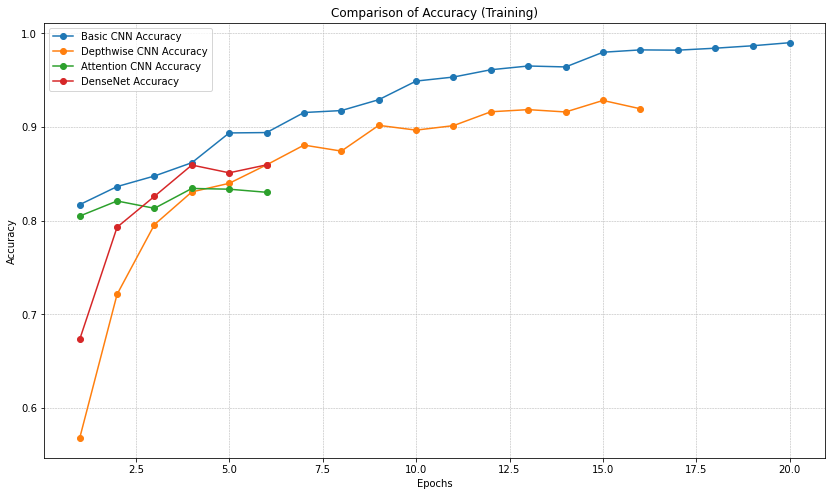

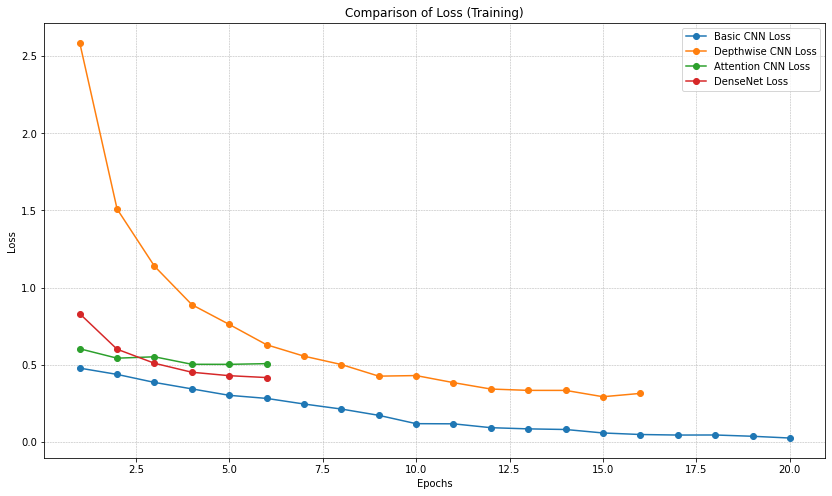

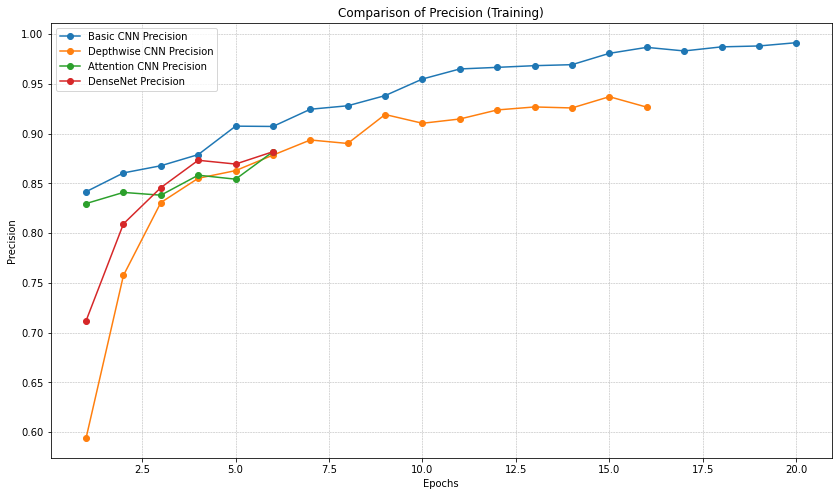

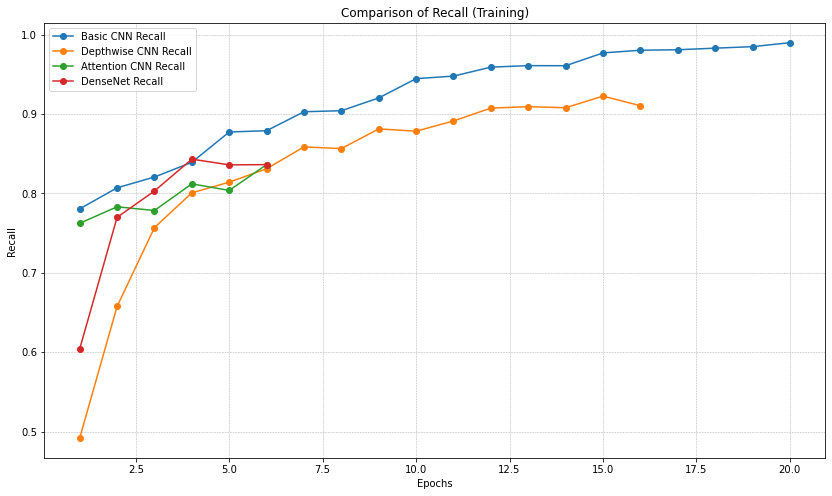

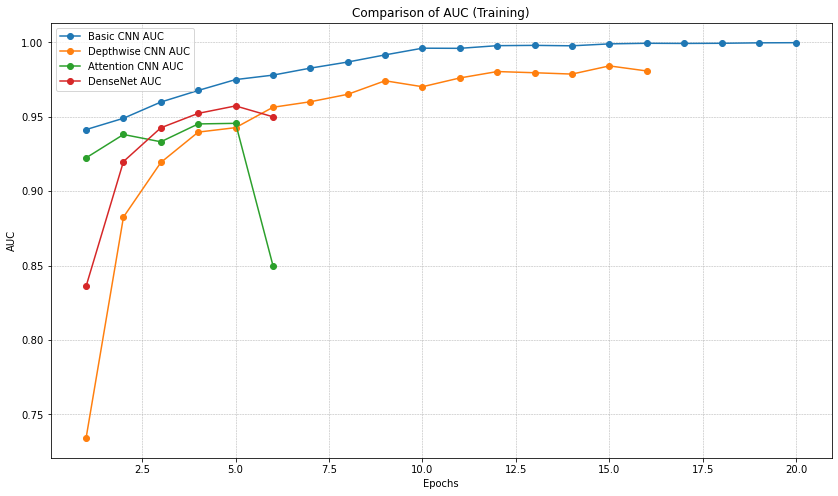

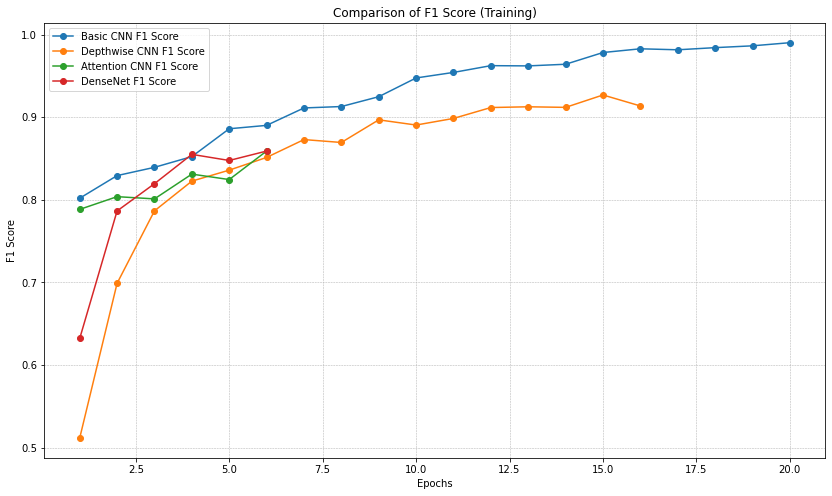

In [6]:
import matplotlib.pyplot as plt

# Combine training and validation metrics into a single dictionary for each model
def combine_metrics(train_metrics, val_metrics):
    combined_metrics = {}
    for key in train_metrics.keys():
        combined_metrics[key] = train_metrics[key]
        combined_metrics[f'val_{key}'] = val_metrics[f'val_{key}']
    return combined_metrics

# Combine the metrics for each model
basic_cnn_metrics = combine_metrics(basic_cnn_train_metrics, basic_cnn_val_metrics)
depthwise_cnn_metrics = combine_metrics(depthwise_cnn_train_metrics, depthwise_cnn_val_metrics)
attention_cnn_metrics = combine_metrics(attention_cnn_train_metrics, attention_cnn_val_metrics)
densenet_metrics = combine_metrics(densenet_train_metrics, densenet_val_metrics)

# Collect all models' metrics
models = {
    'Basic CNN': basic_cnn_metrics,
    'Depthwise CNN': depthwise_cnn_metrics,
    'Attention CNN': attention_cnn_metrics,
    'DenseNet': densenet_metrics
}

# Function to plot comparison for a single metric on training data
def plot_training_comparison(metric, metric_name, models):
    plt.figure(figsize=(14, 8))
    
    for model_name, data in models.items():
        epochs = range(1, len(data[metric]) + 1)
        plt.plot(epochs, data[metric], marker='o', linestyle='-', label=f'{model_name} {metric_name}')
    
    plt.title(f'Comparison of {metric_name} (Training)')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

# Plot comparisons for each metric on training data
plot_training_comparison('accuracy', 'Accuracy', models)
plot_training_comparison('loss', 'Loss', models)
plot_training_comparison('precision', 'Precision', models)
plot_training_comparison('recall', 'Recall', models)
plot_training_comparison('auc', 'AUC', models)
plot_training_comparison('f1_score', 'F1 Score', models)


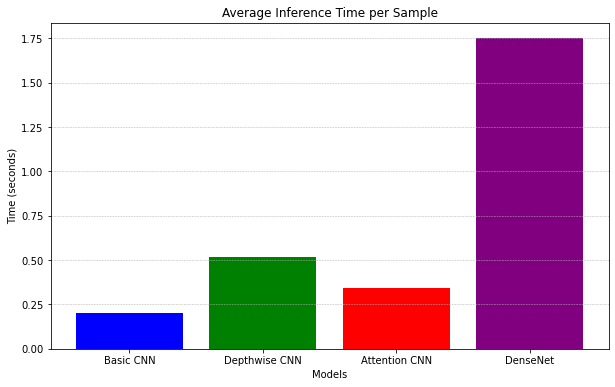

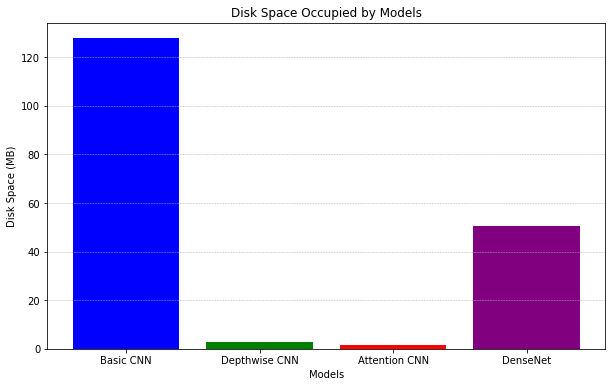

In [7]:
import matplotlib.pyplot as plt

# Inference metrics for each model
inference_metrics = {
    'Basic CNN': {'average_inference_time_per_sample': 0.2002, 'memory_usage_mb': 127.86},
    'Depthwise CNN': {'average_inference_time_per_sample': 0.5185, 'memory_usage_mb': 2.63},
    'Attention CNN': {'average_inference_time_per_sample': 0.3443, 'memory_usage_mb': 1.56},
    'DenseNet': {'average_inference_time_per_sample': 1.7510, 'memory_usage_mb': 50.35}
}

# Extracting the data for plotting
models = list(inference_metrics.keys())
inference_times = [inference_metrics[model]['average_inference_time_per_sample'] for model in models]
memory_usages = [inference_metrics[model]['memory_usage_mb'] for model in models]

# Plotting the Average Inference Time per Sample
plt.figure(figsize=(10, 6))
plt.bar(models, inference_times, color=['blue', 'green', 'red', 'purple'])
plt.title('Average Inference Time per Sample')
plt.xlabel('Models')
plt.ylabel('Time (seconds)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()

# Plotting the Disk Space Occupied by Models
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usages, color=['blue', 'green', 'red', 'purple'])
plt.title('Disk Space Occupied by Models')
plt.xlabel('Models')
plt.ylabel('Disk Space (MB)')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.show()
